In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import statsmodels.api as sm

from colorama import Back, Style, Fore
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as py

from ete3 import Tree
from Bio.Align.Applications import ClustalwCommandline
from Bio import Align , pairwise2

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/genome/sars.fasta
/kaggle/input/genome/plasmodium-malariae.fasta
/kaggle/input/genome/BAT-SARS.fasta
/kaggle/input/genome/mers.fasta
/kaggle/input/genome/cov2.fasta
/kaggle/input/genome/Civet-SARS.fasta
/kaggle/input/genome/camelus.fasta
/kaggle/input/genome/EBOLAV.fasta
/kaggle/input/genome/hiv2.fasta
/kaggle/input/genome/hedgehog.fasta


In [5]:
with open('../input/genome/sars.fasta','r') as file:
    sars_genome = file.read().split('genome')[1].replace('\n','')
    
with open('../input/genome/mers.fasta','r') as file:
    mers_genome = file.read().split('genome')[1].replace('\n','')

with open('../input/genome/cov2.fasta','r') as file:
    cov_genome = file.read().split('genome')[1].replace('\n','')
    
with open('../input/genome/Civet-SARS.fasta','r') as file:
    civet_sl_cov_genome = file.read().split('complete genome')[1].replace('\n','')
    
    
with open('../input/genome/BAT-SARS.fasta','r') as file:
    bat_sl_cov_genome = file.read().split('complete genome')[-1].replace("\n",'')
    
with open('../input/genome/EBOLAV.fasta','r') as file:
    ebola5_genome = file.read().split('complete genome')[-1].replace("\n",'')

with open('../input/genome/camelus.fasta','r') as file:
    camel_cov_genome = file.read().split('complete genome')[-1].replace("\n",'')

with open('../input/genome/plasmodium-malariae.fasta','r') as file:
    maleria_genome = file.read().split('complete sequence')[-1].replace("\n",'')

with open('../input/genome/hiv2.fasta','r') as file:
    hiv2_genome = file.read().split('complete genome')[-1].replace("\n",'')

with open('../input/genome/hedgehog.fasta','r') as file:
    hedgehog_cov_genome = file.read().split('complete genome')[-1].replace("\n",'')

In [6]:
hiv2_genome[:3000]

'TGCAAGGGATGTTTTACAGTAGGAGGAGACATAGAATCCTAGACATATACCTAGAAAAAGAGGAAGGGATAATACCAGATTGGCAGAATTATACTCATGGGCCAGGAGTAAGGTACCCAATGTACTTCGGGTGGCTGTGGAAGCTAGTATCAGTAGAACTCTCACAAGAGGCAGAGGAAGATGAGGCCAACTGCTTAGTACACCCAGCACAAACAAGCAGACATGATGATGAGCATGGGGAGACATTAGTGTGGCAGTTTGACTCCATGCTGGCCTATAACTACAAGGCCTTCACTCTGTACCCAGAAGAGTTTGGGCACAAGTCAGGATTGCCAGAGAAAGAATGGAAGGCAAAACTGAAAGCAAGAGGGATACCATATAGTGAATAACAGGAACAACCATACTTGGTCAAGGCAGGAAGTAGCTACTAAGAAACAGCTGAGGCTGCAGGGACTTTCCAGAAGGGGCTGTAACCAAGGGAGGGACATGGGAGGAGCTGGTGGGGAACGCCCTCATACTTACTGTATAAATGTACCCGCTTCTTGCATTGTATTCAGTCGCTCTGCGGAGAGGCTGGCAGATCGAGCCCTGAGAGGTTCTCTCCAGCACTAGCAGGTAGAGCCTGGGTGTTCCCTGCTGGACTCTCACCAGTACTTGGCCGGTACTGGGCAGACGGCTCCACGCTTGCTTGCTTAAAGACCTCTTCAATAAAGCTGCCAGTTAGAAGCAAGTTAAGTGTGTGTTCCCATCTCTCCTAGTCGCCGCCTGGTCATTCGGTGTTCATCTGAGTAACAAGACCCTGGTCTGTTAGGACCCTTCTCGCTTTGGGAATCCAAGGCAGGAAAATCCCTAGCAGGTTGGCGCCCGAACAGGGACTTGAAGAGGACTGAGAAGCCCTGGAACTCGGCTGAGTGAAGGCAGTAAGGGCGGCAGGAACAAACCACGACGGAGTGCTCCTAGAAAGGCGCGGGCCGAGGTACCAAAGGCGGCGTGTGGAGC

In [7]:
def ten_nucleotide_seq(genome):
    genes = []
    for ix,char in enumerate(genome):
        if ix!=0 and ix%10 ==0 :
            genes.append(' ')
        genes.append(char)
    
    return ''.join(genes)

# color code to represent genome sequences
nu_clr_switcher = {
    # standard color-codes
    'A': Back.GREEN,
    'C': Back.YELLOW,
    'G': Back.RED,
    'T': Back.BLUE,
    ' ': Style.RESET_ALL
}
protein_clr_switcher = {
    # color-code by proteinfamily's polarity
    'A': Back.BLUE,
    'V': Back.BLUE,
    'I': Back.BLUE,
    'L': Back.BLUE,
    'M': Back.BLUE,
    'F': Back.BLUE,
    'Y': Back.CYAN,
    'W': Back.BLUE,
    'H': Back.CYAN,
    'R': Back.RED,
    'K': Back.RED,
    'N': Back.GREEN,
    'Q': Back.GREEN,
    'E': Back.MAGENTA,
    'D': Back.MAGENTA,
    'S': Back.GREEN,
    'T': Back.GREEN,
    'G': Back.YELLOW,
    'P': Back.YELLOW,
    'C': Back.BLUE,
    ' ': Style.RESET_ALL
}

def seq_repr(genome_str , strand = 'dna'):
    if strand == 'dna':
        genome_str = ten_nucleotide_seq(genome_str)
        line_break_ctr = 0
        for i in range(len(genome_str)):
            if genome_str[i] == ' ':
                line_break_ctr += 1
                if line_break_ctr > 0 and line_break_ctr %6 ==0:
                    text = '\n\n'
                else:
                    text = nu_clr_switcher[genome_str[i]] + genome_str[i]
            else:
                text = nu_clr_switcher[genome_str[i]] + genome_str[i]
            print(text , end = '')
    Style.RESET_ALL

    if strand == 'protein':
        for i in range(len(genome_str)):
            if genome_str[i] in protein_clr_switcher:
                if genome_str[i] == 'S' and genome_str[i+1:i+4] == 'TOP':
                    text = Style.RESET_ALL + 'S'
                elif genome_str[i] == 'T' and genome_str[i-1] == 'S' and genome_str[i+1:i+3] == 'OP':
                    text = Style.RESET_ALL + 'T'
                elif genome_str[i] == 'P' and genome_str[i-3:i] == 'STO':
                    text = Style.RESET_ALL + 'P'
                else:
                    text = protein_clr_switcher[genome_str[i]] + genome_str[i]
            
            else:
                Style.RESET_ALL
                text = genome_str[i]
            print(text,end='')

In [8]:
print('COVID19 Genome, First 1000 DNA strands\n\n')
seq_repr(cov_genome[:1000])

COVID19 Genome, First 1000 DNA strands


ATTAAAGGTT TATACCTTCC CAGGTAACAA ACCAACCAAC TTTCGATCTC TTGTAGATCT

GTTCTCTAAA CGAACTTTAA AATCTGTGTG GCTGTCACTC GGCTGCATGC TTAGTGCACT

CACGCAGTAT AATTAATAAC TAATTACTGT CGTTGACAGG ACACGAGTAA CTCGTCTATC

TTCTGCAGGC TGCTTACGGT TTCGTCCGTG TTGCAGCCGA TCATCAGCAC ATCTAGGTTT

CGTCCGGGTG TGACCGAAAG GTAAGATGGA GAGCCTTGTC CCTGGTTTCA ACGAGAAAAC

ACACGTCCAA CTCAGTTTGC CTGTTTTACA GGTTCGCGAC GTGCTCGTAC GTGGCTTTGG

AGACTCCGTG GAGGAGGTCT TATCAGAGGC ACGTCAACAT CTTAAAGATG GCACTTGTGG

CTTAGTAGAA GTTGAAAAAG GCGTTTTGCC TCAACTTGAA CAGCCCTATG TGTTCATCAA

ACGTTCGGAT GCTCGAACTG CACCTCATGG TCATGTTATG GTTGAGCTGG TAGCAGAACT

CGAAGGCATT CAGTACGGTC GTAGTGGTGA GACACTTGGT GTCCTTGTCC CTCATGTGGG

CGAAATACCA GTGGCTTACC GCAAGGTTCT TCTTCGTAAG AACGGTAATA AAGGAGCTGG

TGGCCATAGT TACGGCGCCG ATCTAAAGTC ATTTGACTTA GGCGACGAGC TTGGCACTGA

TCCTTATGAA GATTTTCAAG AAAACTGGAA CACTAAACAT AGCAGTGGTG TTACCCGTGA

ACTCATGCGT GAGCTTAACG GAGGGGCATA CACTCGCTAT GTCGATAACA ACTTCTGTGG

CCCTGATGGC TACCCTCTTG

In [9]:
# tri-nucleotide compositions
trimers = ["AAA", "AAC", "AAG", "AAT", "ACA", "ACC", "ACG", "ACT", "AGA", "AGC", "AGG", "ATA", "ATC", "ATG", "CAA", 
           "CAC", "CAG", "CCA","CCC","CCG","CGA","CGC","CTA","CTC","GAA","GAC","GCA","GCC","GGA","GTA","TAA","TCA"]

def trimer_composition(genome):
    trimer_dict = dict()
    for trimer in trimers:
        trimer_dict[trimer] = genome.count(trimer)
    return trimer_dict

# tetra-nucleotide compositions
tetramers = ['AAAA','AAAC','AAAG','AAAT','AACA','AACC','AACG','AACT','AAGA','AAGC','AAGG','AAGT','AATA','AATC',
             'AATG','AATT','ACAA','ACAC','ACAG','ACAT','ACCA','ACCC','ACCG','ACCT','ACGA','ACGC','ACGG','ACGT',
             'ACTA','ACTC','ACTG','AGAA','AGAC','AGAG','AGAT','AGCA','AGCC','AGCG','AGCT','AGGA','AGGC','AGGG',
             'AGTA','AGTC','AGTG','ATAA','ATAC','ATAG','ATAT','ATCA','ATCC','ATCG','ATGA','ATGC','ATGG','ATTA',
             'ATTC','ATTG','CAAA','CAAC','CAAG','CACA','CACC','CACG','CAGA','CAGC','CAGG','CATA','CATC','CATG',
             'CCAA','CCAC','CCAG','CCCA','CCCC','CCCG','CCGA','CCGC','CCGG','CCTA','CCTC','CGAA','CGAC','CGAG',
             'CGCA','CGCC','CGCG','CGGA','CGGC','CGTA','CGTC','CTAA','CTAC','CTAG','CTCA','CTCC','CTGA','CTGC',
             'CTTA','CTTC','GAAA','GAAC','GACA','GACC','GAGA','GAGC','GATA','GATC','GCAA','GCAC','GCCA','GCCC',
             'GCGA','GCGC','GCTA','GGAA','GGAC','GGCA','GGCC','GGGA','GGTA','GTAA','GTAC','GTCA','GTGA','GTTA',
             'TAAA','TACA','TAGA','TATA','TCAA','TCCA','TCGA','TGAA','TGCA','TTAA']

def tetramer_composition(genome):
    tetramer_dict = dict()
    for tetramer in tetramers:
        if tetramer in genome:
            tetramer_dict[tetramer] = genome.count(tetramer)
        else:
            tetramer_dict[tetramer] = 0
    return tetramer_dict



In [10]:
labels = ["SARS", "MERS", "COVID-19", "Civet_SL_CoV","Bat_SL_CoV","Ebola","Camel_CoV","Malaria","HIV","Hedgehog_CoV"]

traces = []

for i,genome in enumerate((sars_genome,mers_genome,cov_genome,civet_sl_cov_genome,bat_sl_cov_genome,ebola5_genome,camel_cov_genome,maleria_genome,hiv2_genome,hedgehog_cov_genome)):
    composition = trimer_composition(genome)
    total_composition = sum(composition.values())
    norm_freq = [count/total_composition for count in composition.values()]
    traces.append(go.Scatter(x = trimers, y = norm_freq , mode = 'lines',name = labels[i]))
    

layout=go.Layout(
    title="Trinucleotide Composition of genomes",
    xaxis_title="Trinucleotides",
    yaxis_title="Normalized frequencies",
    width=800, height=600
)

fig = go.Figure(data=traces, layout=layout)
py.iplot(fig, filename="3mer-composition-frequency")

In [11]:
labels = ["SARS", "MERS", "COVID-19", "Civet_SL_CoV","Bat_SL_CoV","Ebola","Camel_CoV","Malaria","HIV","Hedgehog_CoV"]

traces = []

for i,genome in enumerate((sars_genome,mers_genome,cov_genome,civet_sl_cov_genome,bat_sl_cov_genome,ebola5_genome,camel_cov_genome,maleria_genome,hiv2_genome,hedgehog_cov_genome)):
    composition = tetramer_composition(genome)
    total_composition = sum(composition.values())
    norm_freq = [count/total_composition for count in composition.values()]
    traces.append(go.Scatter(x = tetramers, y = norm_freq , mode = 'lines',name = labels[i]))
    

layout=go.Layout(
    title="Tetranucleotide Composition of genomes",
    xaxis_title="Tetranucleotides",
    yaxis_title="Normalized frequencies",
    width=1500, height=600
)

fig = go.Figure(data=traces, layout=layout)
py.iplot(fig, filename="4mer-composition-frequency")

**Let's only take covid genomes**

In [12]:
labels = ["SARS", "MERS", "COVID-19", "Civet_SL_CoV","Bat_SL_CoV","Camel_CoV","Hedgehog_CoV"]

traces = []
for i,genome in enumerate((sars_genome,mers_genome,cov_genome,civet_sl_cov_genome,bat_sl_cov_genome,camel_cov_genome,hedgehog_cov_genome)):
    composition = tetramer_composition(genome)
    total_composition = sum(composition.values())
    norm_freq = [count/total_composition for count in composition.values()]
    traces.append(go.Scatter(x = tetramers,y = norm_freq,mode = 'lines',name = labels[i]))

layout = go.Layout(
        title = 'TetraNucleotide Composition of Genome',
        xaxis_title = 'TetraNucleotides',
        yaxis_title = 'Normalized frequencies',
        width = 1200 , height = 600)

fig = go.Figure(data = traces,layout = layout)
py.iplot(fig, filename="4mer-composition-frequency")



GC content (or Guanine-Cytosine content) is the percentage of nucleotides bases in a DNA/RNA molecule that are either guanine (G) or cytosine (C). GC content is always expressed as a percentage value and is supposed to remaine the same among genomes of same specie.

 `(G+C)/(A+C+G+T)×100 %`

In [13]:
def gc_content(genome):
    t_content = genome.count('T')
    g_content = genome.count('G')
    c_content = genome.count('C')
    a_content = genome.count('A')
    return 100*((g_content + c_content)/(t_content+g_content+c_content+a_content))

gc_content_perc = [gc_content(sars_genome),gc_content(mers_genome),gc_content(cov_genome),gc_content(civet_sl_cov_genome),
                   gc_content(camel_cov_genome),gc_content(maleria_genome),gc_content(ebola5_genome),gc_content(hiv2_genome),
                   gc_content(bat_sl_cov_genome),gc_content(hedgehog_cov_genome)]
viruses = ["SARS", "MERS", "COVID-19", "Civet_SL_CoV","Bat_SL_CoV","Ebola","Camel_CoV","Malaria","HIV","Hedgehog_CoV"]

colors = ['lightslategray']*10
colors[2] = 'crimson'

fig = go.Figure(data = [go.Bar(x = viruses,y = gc_content_perc,text = gc_content_perc,marker_color = colors)])

fig.update_traces(texttemplate="%{text:.2f}%", textposition="outside")
fig.update_layout(title_text="GC content distribution among genomes",xaxis_title="Genomes",yaxis_title="GC content (%)")

In [14]:
def gen_protein_seq(genome_str):
    # codon table from wiki
    protein = {"TTT" : "F", "CTT" : "L", "ATT" : "I", "GTT" : "V",
           "TTC" : "F", "CTC" : "L", "ATC" : "I", "GTC" : "V",
           "TTA" : "L", "CTA" : "L", "ATA" : "I", "GTA" : "V",
           "TTG" : "L", "CTG" : "L", "ATG" : "M", "GTG" : "V",
           "TCT" : "S", "CCT" : "P", "ACT" : "T", "GCT" : "A",
           "TCC" : "S", "CCC" : "P", "ACC" : "T", "GCC" : "A",
           "TCA" : "S", "CCA" : "P", "ACA" : "T", "GCA" : "A",
           "TCG" : "S", "CCG" : "P", "ACG" : "T", "GCG" : "A",
           "TAT" : "Y", "CAT" : "H", "AAT" : "N", "GAT" : "D",
           "TAC" : "Y", "CAC" : "H", "AAC" : "N", "GAC" : "D",
           "TAA" : "STOP", "CAA" : "Q", "AAA" : "K", "GAA" : "E",
           "TAG" : "STOP", "CAG" : "Q", "AAG" : "K", "GAG" : "E",
           "TGT" : "C", "CGT" : "R", "AGT" : "S", "GGT" : "G",
           "TGC" : "C", "CGC" : "R", "AGC" : "S", "GGC" : "G",
           "TGA" : "STOP", "CGA" : "R", "AGA" : "R", "GGA" : "G",
           "TGG" : "W", "CGG" : "R", "AGG" : "R", "GGG" : "G" 
           }
    protein_seq = ""
    
    # generating the protein seq
    for i in range(0, len(genome_str)-(3+len(genome_str)%3), 3):
        protein_seq += protein[genome_str[i:i+3]]
    return protein_seq

In [15]:
print("Protein Sequence in Maleria")
seq_repr(gen_protein_seq(maleria_genome), strand = 'protein')

Protein Sequence in Maleria
PTAQIFAIIAMRDGRVYLHPSNTPSTOPGCCRCRVFTLLRLPSGTFDESTTGWEKTSSLYHPGGNHTSTVSWWTILRKAAMGTGRLLLDEKEETPSTOPSCTHEVLGPTARCCSTOPYPIDEVNSTOPAFSTNRGCHQCCRRQFGVLGPHYVPSRREGKCKHLSTOPGLSPKDVLCWYFQSRPSGGSTOPLEELLPISVSPICSTOPNGGHRWEAYYQSTOPDQHLQETPWSLYLQEPGLIFQIIPDSWPPTLNTSISLYGEAMSTOPGEISSTOPEVSTOPGSCDFPSRSEGVTSQSTOPDGRGRLLHRSTOPKVPPLSCPTSTOPCRTFFHSTOPSTOPFGRLSTOPVLHLRRRECLRRSNINDSTOPGTREEVRYHGGDDPLGVYPTQYRPRNLEISLQGYPHSRRFLPSTOPTSYFRFSSTOPGTTWSHEGPSTOPRSHRSPTHVCCLEEKCPSTYGTLSTOPHSGSTOPNGQSTOPSPYRHCGSSMAADPAGTFGAHFKTHDVESPICVLQFSSAGSSLDGGHNDLQVQVVELRRSSILRFEGRDECSRYHLDSSPRETIPKGLWSTTKSLRSTOPLRNRSYWTSTOPRDRPPDGTTYSLAQRYHDGGTHGEAMSHSLEPLCGVLRVAQIQSSTOPVSTOPPGEPPSEALPYWGRSTOPSLSGRSPALSSTOPLYDKVPSSIWVPDRGWSTWYFPYSGTLRGESTVHREFLEEETPSTOPSQELSRIDDCGDHKGQNSSTOPTRISTSYYQRSTOPSTOPECCHRQVLDDISLFEVDAKTPTVARMAQTDDKRPIRVTNGGMATESPETSEVFQSTOPHHASQILRGLWLSHVRPRGIYGLYKSLPTIAVDYRRSLSTOPRPSTMEGRDQRTFPVKPEPLEERRHSTOPVSKVRTRHHSTOPTTHDGLESTOPSSELEATRREVSISSWSTRDSSRGPTGGLHVHKTICRSTOPGDTRCHFPKLSFG

In [16]:
print("Protein Sequence in Covid")
seq_repr(gen_protein_seq(cov_genome), strand = 'protein')

Protein Sequence in Covid


IKGLYLPRSTOPQTNQLSISCRSVLSTOPTNFKICVAVTRLHASTOPCTHAVSTOPLITNYCRSTOPQDTSNSSIFCRLLTVSSVLQPIISTSRFRPGVTERSTOPDGEPCPWFQRENTRPTQFACFTGSRRARTWLWRLRGGGLIRGTSTSSTOPRWHLWLSRSSTOPKRRFASTSTOPTALCVHQTFGCSNCTSWSCYGSTOPAGSRTRRHSVRSSTOPWSTOPDTWCPCPSCGRNTSGLPQGSSSSTOPERSTOPSTOPRSWWPSTOPLRRRSKVISTOPLRRRAWHSTOPSLSTOPRFSRKLEHSTOPTSTOPQWCYPSTOPTHASTOPASTOPRRGIHSLCRSTOPQLLWPSTOPWLPSSTOPVHSTOPRPSSTCWSTOPSFMHFVRTTGLYSTOPHSTOPEGCILLPSTOPTSTOPASTOPNCLVHGTFSTOPKELSTOPIADTFSTOPNSTOPIGKEISTOPHLQWGMSKFCISLKFHNQDYSTKGSTOPKEKASTOPWLYGSTOPNSICLSSCVTKSTOPMQPNVPFNSHEVSTOPSLWSTOPNFMADGRFCSTOPSHLRILWHSTOPEFDSTOPRRCHYLWLLTPKCCCSTOPNLLSSMSQFRSRTSTOPASTOPSCRIPSTOPSTOPIWLENHSSSTOPGWSHYCLWRLCVLLCWLPSTOPQVCLLGSTCSTOPRSTOPHRLSTOPPYRCCWRRFRRSSTOPSTOPQPSSTOPNTPKRESQHQYCWSTOPLSTOPTSTOPSTOPRDRHYFGIFFCFHKCFCGNCERFGLSTOPSIQTNCSTOPILWSTOPFSTOPSYKRKSSTOPKRCLEYWSTOPTEINTESSLCICIRGCSCCTINFLPHSSTOPNCSKFCACFTEGRYNNTRWNFTVFTETHSTOPCYDVHISTOPFGYSTOPQSSCNGLHYRWCCSVDFAVANSTOPHLWHCLSTOPKTQTRPSTOPLASTOPREVSTOPGRCRVSSTOPRRLGNCSTOPIYLNLCLSTOPNCRWT

OPVHVSIKSHSTOPKVEIPTSSTOPWFNFYSTOPMGRSTOPQLLSCHCIVNTPTNRVEVSTOPSTCSTRCLLQSKGWSTOPSCSTOPLLCTYLSLLSTOPSTOPDSRSTOPVRSTOPCSTOPRNNELLVSTCQFRFLQKSLERGVSTOPNLWTTADNPSTOPGCRSCYVHGHTFLSTOPTISTOPERCSDTLYVWSTOPTSYKISSTTGVTFCYDVSTTCSVSTOPTSTOPAWYIYLCSTOPSTOPVHWSTOPLPVWSLSTOPTYNFSTOPRNFVLHRRCFTYKVLRIQRSYYGCFLQRKQLHNNHKTSYLSTOPIGWCCLYRNSTOPPSTOPVGQLLSTOPERQFLFHRATNSTOPSCTKPTISKRKLRSTOPFSTOPVCMSTOPSTOPYQICSTOPSTOPFKPVNWLSTOPETCFKRASTOPSYIFPSTOPLKWSTOPCGGYSTOPLSTOPTLHTLFSTOPERSSTOPIVTSTOPTYCLACSTOPQCNSTOPSTOPSHVSTOPTKYLVYTLSLEHKTSSTOPNIKFVSTOPCTEVRGRAGNGSTOPSCLRRSKTSLSTOPRSSGKSYHTERRSSTOPVSTOPCENYRSCRRHYTSTOPTSKSTOPSTOPFKNYRRGWPHRSNGCLCRQFSTOPSYYSTOPETSTOPSTOPIISTOPSIRFENPCYSWFSCCSTOPSTOPCPLGYYSSTOPLCSTOPAFSSTOPQSCSTOPYNYSTOPHSYTVFKPCLYSTOPLYALFLYFIATIVYFYSTOPKYKFSTOPNSTOPSIYADYYSKEYCSTOPECRSTOPILSRGFISTOPLFEVTSTOPFFSTOPTDKYYNLVFTIKCLPRFFNLLNRCFRCFNVSTOPFRHAFLLYWLQRRLFELYSTOPCHYCNLLYWFYTLSTOPCLSSTOPWFRFFRHLSFFRNYTNYHFIFSTOPMGFNCFWLSCRVVFGIYSFHSTOPVFLCTWIGCNHAIVFQLFCSTFYSTOPSTOPFLAYVVNNSTOPSCTNGPDFSYGS

NFSTOPFSTOPVLSTOPARHLSTOPKIRSWCLCIYSTOPWSTOPMGTSTOPQSTOPLLQIFTRSFLWCRCCKFTYSTOPYVYTTNSTYWCFGHISIYSSWWYCSYRSNMPCLLFYEVSTOPKSFWSTOPIQSCSCLSTOPYFTIPYVIHCTLFNTSLLILTWCLFCYLLVLDILSYSTOPSTOPCFFFSTYSVDGYVHTFSTFLDNNCLYHLYFHKAFLLVLSTOPSTOPLPKETCSLSTOPWCFLSTOPYFSTOPRSCAVHLFVKSTOPRNVSKVASTOPSTOPCAITSYAISTOPSTOPILSSLSTOPSTOPVQVFSTOPWSNGYNSTOPLQRSCLLSSRKGSQSTOPLQSTOPLRFSTOPCSLPTTTNLYHLSCFAEWFSTOPKNGIPIWSTOPSSTOPGLYGTSNLWYNYTSTOPRSLASTOPSTOPRSLLSKTCDLHLSTOPRHASTOPPSTOPLSTOPRFTHSSTOPVSTOPSSTOPFLGTGWSTOPCSTQGYWTFYAKLCTSTOPASTOPGSTOPYSQSSTOPDTSTOPVSTOPVCSHSTRTDFFSVSLLQWFTIWCLPMCYEAQFHYSTOPGFIPSTOPWFMWSTOPCWFSTOPHRLSTOPLCLFLLHAPYGITNWSSCWHRLRRSTOPLLWTFCSTOPQANSTSSWYGHNYYSSTOPCFSLVVRCCYKWRQVVSQSIYHNSSTOPSTOPLSTOPPCGYEVQLSTOPTSNTRPCSTOPHTRTSFCSNWNCRFRYVCFIKRITAKWYEWTYHIGSTOPCFIRRSTOPIYTFSTOPCCSTOPTMLRCYFPKCSEKNNQGYTPLVVTHNFDFTFSFSPEYSMVFVLFFVSTOPKCLFTFCYGYYCYVCFCNDVCQTSTOPACISLFVFVTFSCHCSLFSTOPYGLYACSTOPLGDAYYDMVGYGSTOPYSTOPFVWFSTOPAKRLCYVCISCSVTNPYDSKNCVSTOPSTOPWCSTOPESVDTYECLDTRLSTOPSLLWSTOPCFRSSHFHVGSY

YALRHFDEGNCDTLKEILVTYNCCDDDYFNKKDWYDFVENPDILRVYANLGERVRQALLKTVQFCDAMRNAGIVGVLTLDNQDLNGNWYDFGDFIQTTPGSGVPVVDSYYSLLMPILTLTRALTAESHVDTDLTKPYIKWDLLKYDFTEERLKLFDRYFKYWDQTYHPNCVNCLDDRCILHCANFNVLFSTVFPPTSFGPLVRKIFVDGVPFVVSTGYHFRELGVVHNQDVNLHSSRLSFKELLVYAADPAMHAASGNLLLDKRTTCFSVAALTNNVAFQTVKPGNFNKDFYDFAVSKGFFKEGSSVELKHFFFAQDGNAAISDYDYYRYNLPTMCDIRQLLFVVEVVDKYFDCYDGGCINANQVIVNNLDKSAGFPFNKWGKARLYYDSMSYEDQDALFAYTKRNVIPTITQMNLKYAISAKNRARTVAGVSICSTMTNRQFHQKLLKSIAATRGATVVIGTSKFYGGWHNMLKTVYSDVENPHLMGWDYPKCDRAMPNMLRIMASLVLARKHTTCCSLSHRFYRLANECAQVLSEMVMCGGSLYVKPGGTSSGDATTAYANSVFNICQAVTANVNALLSTDGNKIADKYVRNLQHRLYECLYRNRDVDTDFVNEFYAYLRKHFSMMILSDDAVVCFNSTYASQGLVASIKNFKSVLYYQNNVFMSEAKCWTETDLTKGPHEFCSQHTMLVKQGDDYVYLPYPDPSRILGAGCFVDDIVKTDGTLMIERFVSLAIDAYPLTKHPNQEYADVFHLYLQYIRKLHDELTGHMLDMYSVMLTNDNTSRYWEPEFYEAMYTPHTVLQAVGACVLCNSQTSLRCGACIRRPFLCCKCCYDHVISTSHKLVLSVNPYVCNAPGCDVTDVTQLYLGGMSYYCKSHKPPISFPLCANGQVFGLYKNTCVGSDNVTDFNAIATCDWTNAGDYILANTCTERLKLFAAETLKATEETFKLSYGIATVREVLSDRELHLSWEVGKPRPPLNRNYVFTGYRVTKNSKVQIG

EVKILNNLGVDIAANTVIWDYKRDAPAHISTIGVCSMTDIAKKPTETICAPLTVFFDGRVDGQVDLFRNARNGVLITEGSVKGLQPSVGPKQASLNGVTLIGEAVKTQFNYYKKVDGVVQQLPETYFTQSRNLQEFKPRSQMEIDFLELAMDEFIERYKLEGYAFEHIVYGDFSHSQLGGLHLLIGLAKRFKESPFELEDFIPMDSTVKNYFITDAQTGSSKCVCSVIDLLLDDFVEIIKSQDLSVVSKVVKVTIDYTEISFMLWCKDGHVETFYPKLQSSQAWQPGVAMPNLYKMQRMLLEKCDLQNYGDSATLPKGIMMNVAKYTQLCQYLNTLTLAVPYNMRVIHFGAGSDKGVAPGTAVLRQWLPTGTLLVDSDLNDFVSDADSTLIGDCATVHTANKWDLIISDMYDPKTKNVTKENDSKEGFFTYICGFIQQKLALGGSVAIKITEHSWNADLYKLMGHFAWWTAFVTNVNASSSEAFLIGCNYLGKPREQIDGYVMHANYIFWRNTNPIQLSSYSLFDMSKFPLKLRGTAVMSLKEGQINDMILSLLSKGRLIIRENNRVVISSDVLVNNSTOPTNNVCFSCFIATSLSTOPSVCSTOPSYNQNSITPCIHSTOPFFHTWCLLPSTOPQSFQILSFTFNSGLVLTFLFQCYLVPCYTCLWDQWYSTOPEVSTOPSTOPPCPTISTOPSTOPWCLFCFHSTOPEVSTOPHNKRLDFWYYFRFEDPVPTYCSTOPSTOPRYSTOPCCYSTOPSLSTOPISILSTOPSTOPSIFGCLLPQKQQKLDGKSTOPVQSLFSTOPCESTOPLHFSTOPICLSAFSYGPSTOPRKTGSTOPFQKSSTOPGICVSTOPEYSTOPWLFSTOPNIFSTOPAHAYSTOPFSASTOPSPSGFFGFRTIGRFANRYSTOPHHSTOPVSNFTCFTSTOPKLFDSWSTOPFFFRLDSWCCSLLCGLSSTSTOPDFSIKISTOPSTOPKWNHYRCCRLCTSTOPPSLRNK

FLWKGLSSYVLPSVSTSWCSLLACDLCPCTRKELHNCSCHLSSTOPWKSTLSSSTOPRCLCFKWHTLVCNTKEFLSTOPTTNHYYRQHICVWSTOPLSTOPCCNRNCQQHSLSTOPSFATSTOPIRLIQGGVRSTOPIFSTOPESYITRCSTOPFRSTOPHLWHSTOPCFSCKHSKRNSTOPPPQSTOPGCQEFKSTOPISHRSPRTWKVSTOPAVYKMAMVHLARFYSWLDCHSNGDNYALLYDQLLSTOPLSQGLLFLWILLQISTOPSTOPRRLSTOPASAQRSQITLHINELMDLFMRIFTIGTVTLKQGEIKDATPSDFVRATATIPIQASLPFGWLIVGVALLAVFQSASKIITLKKRWQLALSKGVHFVCNLLLLFVTVYSHLLLVAAGLEAPFLYLYALVYFLQSINFVRIIMRLWLCWKCRSKNPLLYDANYFLCWHTNCYDYCIPYNSVTSSIVITSGDGTTSPISEHDYQIGGYTEKWESGVKDCVVLHSYFTSDYYQLYSTQLSTDTGVEHVTFFIYNKIVDEPEEHVQIHTIDGSSGVVNPVMEPIYDEPTTTTSVPLSTOPAQADEYELMYSFVSEETGTLIVNSVLLFLAFVVFLLVTLAILTALRLCAYCCNIVNVSLVKPSFYVYSRVKNLNSSRVPDLLVSTOPTNSTOPILYSTOPFFCLELSTOPFSTOPPWQIPTVLLPLKSLKSSLNNGTSTOPSTOPSTOPVSYSLHGFVFYNLPMPTGIGFCISTOPLSSTOPFSSGCYGQSTOPLSTOPLVLCLLLFTESTOPIGSPVELLSQWLVLSTOPASTOPCGSATSLLLSDCLRVRVPCGHSIQKLTFFSTCHSMALFSTOPPDRFSTOPKVNSSTOPSELSTOPSFVDIFVLLDTISTOPDAVTSRTCLKKSLLLHHERFLITNWELRSVSTOPQVTQVLLHTVATGLATINSTOPTQTIPVAVTILLCLYSKSTOPQQMFHLVDFQVTIAEILLIIMRTFKVSIWNL

LYGRALMCKINFSSAIPMSTOPFSTOPSTOPLLRRMTKKKKKKKKK

In [17]:
genomes = {"SARS": sars_genome , "MERS":mers_genome , "Covid-19":cov_genome , "Civet_SL_COV":civet_sl_cov_genome , 
               "BAT_SL_COV":bat_sl_cov_genome , "EBOLA":ebola5_genome , "Camel_COV":camel_cov_genome,"Maleria":maleria_genome,
           "HIV":hiv2_genome,"HedgeHog_COV":hedgehog_cov_genome}

colors = ["slategray"] * 10
colors[2] = "crimson"

fig = go.Figure(data=[go.Bar(
    x=list(genomes.keys()),
    y=[len(gen_protein_seq(genome).split('STOP')) for genome in genomes.values()],
    text=[len(gen_protein_seq(genome).split('STOP')) for genome in genomes.values()],
    marker_color=colors
)])

fig.update_traces(texttemplate="%{text:.2s}", textposition="outside")
fig.update_layout(
    title_text="Number of protein strands among genomes",
    xaxis_title="Genomes",
    yaxis_title="number of protein strands"
)

In [18]:
def amino_acids_composition(protein_seq):
    amino_acids_dict = {'Y':0,'A':0,'C':0,'D':0,'E':0,'F':0,'G':0,'H':0,'I':0,'K':0,'L':0,'M':0,'N':0,
                       'P':0,'Q':0,'R':0,'S':0,'T':0,'V':0,'W':0}
    
    for amino_acid in amino_acids_dict:
        amino_acids_dict[amino_acid] = protein_seq.count(amino_acid)/len(protein_seq)*100
    return amino_acids_dict
    

In [19]:
fig = go.Figure()
for i in range(10):
    fig.add_trace(go.Bar(x = list(amino_acids_composition(gen_protein_seq(list(genomes.values())[i])).keys()),
                         y = list(amino_acids_composition(gen_protein_seq(list(genomes.values())[i])).values()),
                         name = list(genomes.keys())[i]))
    
    fig.update_layout(barmode = 'group',
                     title="Distribution of Amino Acids by genomes", 
                     xaxis_title="Amino Acids", 
                     yaxis_title="Normalized Frequency (%)")
    
fig.show()
                    

In [20]:
proteins_seq = {}
for genome_name , genome_seq in genomes.items():
    proteins_seq[genome_name] = gen_protein_seq(genome_seq)

protein_seq_length = {}

for genome_name , protein_seq in proteins_seq.items():
    len_of_pro_seq = []
    for seq in protein_seq.split('STOP'):
        len_of_pro_seq.append(len(seq)+1)
    protein_seq_length[genome_name] = len_of_pro_seq

fig = make_subplots(rows = 2 , cols = 1 , subplot_titles = ('Length of Longest Protein Seq' , 'Average Length of Protein Seq'))

fig.add_trace(
        go.Bar(
        x = list(protein_seq_length.keys()),
        y = [max(_len) for _len in protein_seq_length.values()],
        text = [max(_len) for _len in protein_seq_length.values()],
        texttemplate="%{text:.1s}", textposition="outside",
        marker_color=colors),
        row=1, col=1)

fig.add_trace(
    go.Bar(
    x=list(protein_seq_length.keys()),
    y=[sum(lens)/len(lens) for lens in protein_seq_length.values()],
    text=[sum(lens)/len(lens) for lens in protein_seq_length.values()],
    texttemplate="%{text:.2f}", textposition="outside",
    marker_color=colors),
    row=2, col=1
)

fig.update_layout(title_text="Comparative Summary of Protein Sequences",
                  height=960, width=960, showlegend=False)

fig.show()
type(proteins_seq)

dict

In [21]:
sars_genome_aligned = ClustalwCommandline('clustalw2',infile = sars_genome)
mers_genome_aligned = ClustalwCommandline('clustalw2',infile = mers_genome)
hiv2_genome_aligned = ClustalwCommandline('clustalw2',infile = hiv2_genome)
civet_sl_cov_genome_aligned = ClustalwCommandline('clustalw2',infile = civet_sl_cov_genome)
cov_genome_aligned = ClustalwCommandline('clustalw2',infile = cov_genome)
bat_sl_cov_genome_aligned = ClustalwCommandline('clustalw2',infile = bat_sl_cov_genome)
ebola5_genome_aligned = ClustalwCommandline('clustalw2',infile = ebola5_genome)
camel_cov_genome_aligned = ClustalwCommandline('clustalw2',infile = camel_cov_genome)
maleria_genome_aligned = ClustalwCommandline('clustalw2',infile = maleria_genome)
hedgehog_cov_genome_aligned = ClustalwCommandline('clustalw2',infile = hedgehog_cov_genome)

In [22]:
# comparing first 57 nucleotides' of all the genomes after aligning them
print("SARS:\t ",end=" ")
seq_repr(sars_genome_aligned.infile[:57])
print(Style.RESET_ALL + "\nMERS:\t ",end=" ")
seq_repr(mers_genome_aligned.infile[:57])
print(Style.RESET_ALL + "\nCOVID:\t ",end=" ")
seq_repr(cov_genome_aligned.infile[:57])
print(Style.RESET_ALL + "\nBAT:\t ",end=" ")
seq_repr(bat_sl_cov_genome_aligned.infile[:57])
print(Style.RESET_ALL + "\nCIVET:\t ",end=" ")
seq_repr(civet_sl_cov_genome_aligned.infile[:57])
print(Style.RESET_ALL + "\nCAMEL:\t ",end=" ")
seq_repr(camel_cov_genome_aligned.infile[:57])
print(Style.RESET_ALL + "\nHEDGEHOG:",end=" ")
seq_repr(hedgehog_cov_genome_aligned.infile[:57])
print(Style.RESET_ALL + "\nEBOLA:\t ",end=" ")
seq_repr(ebola5_genome_aligned.infile[:57])
print(Style.RESET_ALL + "\nMALARIA: ",end=" ")
seq_repr(maleria_genome_aligned.infile[:57])
print(Style.RESET_ALL + "\nHIV:\t ",end=" ")
seq_repr(hiv2_genome_aligned.infile[:57])

SARS:	  ATATTAGGTT TTTACCTACC CAGGAAAAGC CAACCAACCT CGATCTCTTG TAGATCT
MERS:	  GATTTAAGTG AATAGCTTGG CTATCTCACT TCCCCTCGTT CTCTTGCAGA ACTTTGA
COVID:	  ATTAAAGGTT TATACCTTCC CAGGTAACAA ACCAACCAAC TTTCGATCTC TTGTAGA
BAT:	  ATATTAGGTT TTTACCTACC CAGGAAAAGC CAACCAACCT CGATCTCTTG TAGATCT
CIVET:	  AAGCCAACCA ACCTCGATCT CTTGTAGATC TGTTCTCTAA ACGAACTTTA AAATCTG
CAMEL:	  GATTTAAGTG AATAGCTTGG CTATCTCACT TCCCCTCGTT CTCTTGCAGA ACTTTGA
HEDGEHOG: GATTAAAGAG AATAGCATAG CTATCCCTCT CTCTCCGTTC TCTTGTAGAA CTCTTGT
EBOLA:	  CGGACACACA AAAAGAAAGA AGAATTTTTA GGATCTTTTG TGTGCGAATA ACTATGA
MALARIA:  CCTACGGCTC AAATTTTTGC TATAATAGCA ATGCGTGATG GAAGAGTATA CCTACAT
HIV:	  TGCAAGGGAT GTTTTACAGT AGGAGGAGAC ATAGAATCCT AGACATATAC CTAGAAA

In [23]:
print("Aligning the first 100 nucleotides of COVID-19 genome with every other genomes:\n\n")
for genome_name, genome in genomes.items():
    if genome_name != 'Covid-19':
        print("** COVID-19 and {} genome **".format(genome_name))
        alignments = pairwise2.align.globalxx(cov_genome[:100], genome[:200])
        print(pairwise2.format_alignment(*alignments[0], full_sequences=True))

Aligning the first 100 nucleotides of COVID-19 genome with every other genomes:


** COVID-19 and SARS genome **
ATTAA--AGGTTTAT-ACCTT-CCCAGGTAACAAA-CCAACCAACTT-TCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGT-G--G-C--T-G--T-CA--C-T----C--------------------------------------------------------------------------------------
| | |  |||||| | ||| | ||||||  | ||| |||||||||   ||||||||||||||||||||||||||||||||||||||||||||||| |  | |  | |  | ||  | |    |                                                                                      
A-T-ATTAGGTTT-TTACC-TACCCAGG--A-AAAGCCAACCAAC--CTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTAGCTGTCGCTCGGCTGCATGCCTAGTGCACCTACGCAGTATAAACAATAATAAATTTTACTGTCGTTGACAAGAAACGAGTAACTCGTCCCTCTTCTGCAGACTGCTTACGGTT
  Score=91

** COVID-19 and MERS genome **
-ATTA-AAG-G--T---TT----AT---AC--C---T--T-C-C---CAGGTAAC----A----AACC-AACC--AA-------C--T-TT------CG-ATC-T--C--TTGTA--G-----ATCTGTT--C-TCTAAA----C--GAACT--T-TA---A----A-ATC-TG-TG------TGG--------CT----G--TCACT------

In [24]:
print("Aligning the first 100 amino acids of COVID-19 genome's protein sequence with every other genomes's protein sequence:\n\n")

for genome_name, proteinSeq in proteins_seq.items():
    if genome_name != 'Covid-19':
        print("COVID-19 and {} genomes' protein sequences\n".format(genome_name))
        alignments = pairwise2.align.globalxx(gen_protein_seq(cov_genome[:100]).replace('STOP','*'), proteinSeq[:100].replace('STOP','*'))
        print(pairwise2.format_alignment(*alignments[0], full_sequences=True))

Aligning the first 100 amino acids of COVID-19 genome's protein sequence with every other genomes's protein sequence:


COVID-19 and SARS genomes' protein sequences

IKGL--YLPR*--Q-TNQLSISCRSVL*TNFKICVAV---------------------------------------------------------
|  |  ||||   | |   ||||||||||||||||||                                                         
I--LGFYLPR-KSQPT---SISCRSVL*TNFKICVAVARLHA*CTYAV*TIINFTVVDKKRVTRPSSADCLRFRPCCSRSSAYLGFVRV*PKGK
  Score=26

COVID-19 and MERS genomes' protein sequences

IKG-L-----YL--PR-----*Q---TNQ----L--SI-SCR---S---V-L-----*TNFK---IC-------------V-A-----V---------
    |     ||  ||     |    |      |  |  |     |   | |     |       ||             | |     |         
---DLSE*LGYLTSPRSLAEL*-F*RT--*IKALLFS-VS--LHLSGGIVALICLLI*----AVDICSTLGIILIEYYFSVRASCLLYVSVTIHGFVR
  Score=19

COVID-19 and Civet_SL_COV genomes' protein sequences

IKGLYLPR*QTNQLS----I-S-------C--RS----V-L-----------*--T-N---FKIC----VA--V---------------------------
 |    |   || |     | |    

In [25]:
aligner = Align.PairwiseAligner()
aligner.mode = 'global'
aligner.match_score = 1
aligner.mismatch_score = -0.5
aligner.open_gap_score = 0
aligner.extend_gap_score = 0

In [26]:
print("Similarity scores between\n")
for genome_name, genome in genomes.items():
    if genome_name != 'Covid-19':
        score = aligner.score(cov_genome, genome)
        print("COVID-19 & {} genome sequences:\t {} ({:.2f}%)".format(genome_name, score,100*(score/len(cov_genome))))

Similarity scores between

COVID-19 & SARS genome sequences:	 24794.0 (82.91%)
COVID-19 & MERS genome sequences:	 20900.0 (69.89%)
COVID-19 & Civet_SL_COV genome sequences:	 24560.0 (82.13%)
COVID-19 & BAT_SL_COV genome sequences:	 24677.0 (82.52%)
COVID-19 & EBOLA genome sequences:	 15189.0 (50.79%)
COVID-19 & Camel_COV genome sequences:	 20908.0 (69.92%)
COVID-19 & Maleria genome sequences:	 3057.0 (10.22%)
COVID-19 & HIV genome sequences:	 9917.0 (33.16%)
COVID-19 & HedgeHog_COV genome sequences:	 20966.0 (70.11%)


In [27]:
# Edit Distance algorithm
def edit_distance(genome1,genome2):
    numRows = len(genome1)+1
    numCols = len(genome2)+1
    distance = np.zeros(shape = (numRows,numCols) , dtype = np.int64)
    
    
    for i in range(numRows):
        distance[i][0] = i
    for j in range(numCols):
        distance[0][j] = j
    for i in range(1,len(genome1)+1):
        for j in range(1,len(genome2)+1):
            if genome1[i-1] == genome2[j-1]:
                distance[i][j] = distance[i-1][j-1]
            else:
                distance[i][j] = min(distance[i-1][j],distance[i][j-1],distance[i-1][j-1])+1
    
    return distance[len(genome1)][len(genome2)]
                

So, the edit distance between 'Horse' and 'Ros' is 3. In edit distance algorithm we do 3 operations to match string with another string. These 3 operations are Insertion, Deletion and Replace. 
So in our above example if we replace H by R, it become Rorse, then delete r at position 3 which gives rose, then delete e at last position. 
So Replace, Delete and Delete are three opearations to convert Horse into Ros.

In [28]:
edit_distance('Horse','Ros')

3

In [29]:
def get_list(genome):
    genome_list = []
    j = 0
    for i in range(100,len(genome),100):
        genome_list.append(genome[j:i])
        j = i
    genome_list.append(genome[i:])
    return genome_list

def get_random_sample(genome_list):
    return random.sample(genome_list,k = 500)

def get_random_sample_repetetion(genome_list):
    return random.choices(genome_list, k = 700)

In [30]:
cov_genome_list = get_list(cov_genome)
sars_genome_list = get_list(sars_genome)
mers_genome_list = get_list(mers_genome)
civet_sl_cov_genome_list = get_list(civet_sl_cov_genome)
hiv2_genome_list = get_list(hiv2_genome)
bat_sl_cov_genome_list = get_list(bat_sl_cov_genome)
hedgehog_cov_genome_list = get_list(hedgehog_cov_genome)
maleria_genome_list = get_list(maleria_genome)
camel_cov_genome_list = get_list(camel_cov_genome)
ebola5_genome_list = get_list(ebola5_genome)

Randomly generated sequences from genome

In [31]:
random_genome = {'SARS':get_random_sample_repetetion(sars_genome_list) , 'MERS':get_random_sample_repetetion(mers_genome_list),
                 'Civet_COV': get_random_sample_repetetion(civet_sl_cov_genome_list) , 'HIV2':get_random_sample_repetetion(hiv2_genome_list),
                 'Maleria':get_random_sample_repetetion(maleria_genome_list) , 'Bat_COV':get_random_sample_repetetion(bat_sl_cov_genome_list),
                 'Hedgehog_COV':get_random_sample_repetetion(hedgehog_cov_genome_list) , 'Camel_COV':get_random_sample_repetetion(camel_cov_genome_list),
                'EBOLA':get_random_sample_repetetion(ebola5_genome_list) ,'COVID':get_random_sample_repetetion(cov_genome_list)}

In [32]:
cov_sars = []
for i in range(500):
    cov_sars.append(edit_distance(random_genome['SARS'][i],random_genome['COVID'][i]))

In [33]:
edit_distance_dict = {}
for genome_name , genome in random_genome.items():
    score = []
    if genome_name != "COVID":
        for i in range(700):
            score.append(edit_distance(random_genome[genome_name][i],random_genome['COVID'][i]))
        edit_distance_dict[genome_name] = score

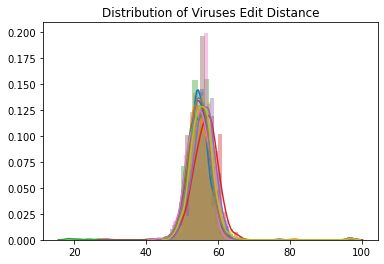

In [34]:
for genome_name , distribution in edit_distance_dict.items():
    sns.distplot(distribution).set(title = "Distribution of Viruses Edit Distance")

In [35]:
for genome_name in edit_distance_dict.keys():
    edit_distance_dict[genome_name] = np.array(edit_distance_dict[genome_name])
dataset = pd.DataFrame(columns = edit_distance_dict.keys())

for name in dataset.columns:
    dataset[name] = edit_distance_dict[name]
dataset.head()

,SARS,MERS,Civet_COV,HIV2,Maleria,Bat_COV,Hedgehog_COV,Camel_COV,EBOLA
0,54,50,53,60,53,52,50,48,57
1,56,60,54,58,55,50,55,60,59
2,58,52,50,56,57,59,57,56,60
3,56,55,55,57,51,54,55,58,55
4,55,55,54,61,60,52,57,52,58


In [36]:
genomes = {"SARS": sars_genome , "MERS":mers_genome , "Covid-19":cov_genome , "Civet_SL_COV":civet_sl_cov_genome , 
               "BAT_SL_COV":bat_sl_cov_genome , "EBOLA":ebola5_genome , "Camel_COV":camel_cov_genome,"Maleria":maleria_genome,
           "HIV":hiv2_genome,"HedgeHog_COV":hedgehog_cov_genome}
def generate_random_Reads(genome , numReads , readLen):
    reads = []
    for _ in range(numReads):
        start = random.randint(0,len(genome)-readLen)-1
        reads.append(genome[start:start+readLen])
    return reads

In [37]:
generate_random_bases_dict = {}

for name in genomes.keys():
    generate_random_bases_dict[name] = generate_random_Reads(genomes[name] , 500 , 100)

In [38]:
def gc_content_by_pos(reads):
    gc = [0]*100
    total = [0]*100
    for read in reads:
        for i in range(len(read)):
            if read[i] == 'G' or read[i] == 'C':
                gc[i] += 1
            total[i] += 1
        
    for i in range(len(gc)):
        if total[i] >= 0:
            gc[i] /= float(total[i])
    return gc

gc_content_pos_dict = {}

for name, genome in generate_random_bases_dict.items():
    x = gc_content_by_pos(genome)
    gc_content_pos_dict[name] = x

In [39]:
labels = ["SARS", "MERS", "COVID-19", "Civet_SL_CoV","Bat_SL_CoV","Ebola","Camel_CoV","Malaria","HIV","Hedgehog_CoV"]
traces = []

for i,genome in gc_content_pos_dict.items():
    traces.append(go.Scatter(x = list(range(0,100)), y = genome , mode = 'lines',name = i))
    

layout=go.Layout(
    title="GC content by position",
    xaxis_title="Index",
    yaxis_title="GC_Content",
    width=1000, height=600
)

fig = go.Figure(data=traces, layout=layout)
py.iplot(fig, filename="GC_content_by_pos")

In [40]:
edit_distance_random_dict = {}

for genome_name, seqs in generate_random_bases_dict.items():
    edit = []
    if genome_name != 'Covid-19':
        for i in range(len(seqs)):
            edit.append((edit_distance(seqs[i] , generate_random_bases_dict['Covid-19'][i]))/abs(len(cov_genome) - len(genomes[genome_name])))
    
    edit_distance_random_dict[genome_name] = edit

In [41]:
del edit_distance_random_dict['Covid-19']
dataset = pd.DataFrame(columns = edit_distance_random_dict.keys())

for name in dataset.columns:
    edit_distance_random_dict[name] = np.array(edit_distance_random_dict[name])
    dataset[name] = edit_distance_random_dict[name]
dataset.head()

,SARS,MERS,Civet_SL_COV,BAT_SL_COV,EBOLA,Camel_COV,Maleria,HIV,HedgeHog_COV
0,0.361842,0.277778,0.154270,0.389610,0.004934,0.254545,0.002123,0.003070,0.224490
1,0.355263,0.259259,0.148760,0.324675,0.005117,0.259091,0.002011,0.002763,0.228571
2,0.348684,0.240741,0.143251,0.357143,0.004660,0.231818,0.002123,0.002968,0.224490
3,0.381579,0.250000,0.140496,0.370130,0.004751,0.250000,0.002123,0.003070,0.212245
4,0.388158,0.268519,0.162534,0.370130,0.005208,0.250000,0.002198,0.002865,0.212245


**As we can observe that, with 95% confidence we estimate that the edit distance of covid genome is much lower with Maleria, Ebola and HIV. It means that covid 19 genome is more similar with maleria, ebola and HIV**

In [42]:
for name in dataset.columns:
    print(name ,sm.stats.DescrStatsW(dataset[name]).zconfint_mean())

SARS (0.35652056222392914, 0.3599004904076497)
MERS (0.2513774735424405, 0.25373363756867057)
Civet_SL_COV (0.14920590887234214, 0.15080511041140443)
BAT_SL_COV (0.3545776416848816, 0.35801976091252097)
EBOLA (0.005030019771340912, 0.005075974380705871)
Camel_COV (0.24637787705397843, 0.24878575930965788)
Maleria (0.0020919269878984315, 0.0021104122805214454)
HIV (0.002859766866391019, 0.0028876748036867563)
HedgeHog_COV (0.2201449803042078, 0.22227134622640446)


*Do upvote if you like it*